In [ ]:
##THIS CODE SNIPPET IS USED TO SETUP THE PGM
!pip3 install PyWavelets

#This should come with conda. Uncomment if trying it raw
#!pip3 install matplotlib scipy xlrd pandas

In [1]:
import pywt
import numpy as np
from numpy.fft import fft2,ifft2
from  scipy.signal import wiener
from scipy.io import loadmat
from scipy.misc import imsave
import pandas


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

#exp1=np.loadtxt('sttest1.txt')
#noobj20082018=np.loadtxt('noobject.txt')
data_folders='images/'
exp1=np.load(data_folders+'sttest1.npy')
noobj20082018=np.load(data_folders+'noobject.npy')

A=exp1[:512,:640]
B=exp1[:512,640:1280]

M=noobj20082018[:512,:640]
N=noobj20082018[:512,640:1280]

L=A/M
H=B/N


concatenated L&H image, noobject image


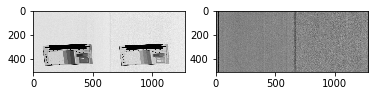

In [4]:
print('concatenated L&H image, noobject image')

plt.subplot(1,2,1)
plt.imshow(exp1,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(noobj20082018,cmap='gray')

L and H images


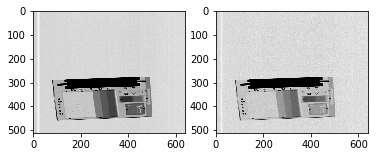

In [5]:
print('L and H images')
plt.subplot(1,2,1)
plt.imshow(L,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(H,cmap='gray')

In [6]:
LE=0.5*L**3.8
HE=0.6*H**0.2
a1,(h1,v1,d1)=pywt.dwt2(LE,'haar')
a2,(h2,v2,d2)=pywt.dwt2(HE,'haar')

k1,k2=a1.shape
ahvd3=(a1+a2,(h1+h2,v1+v2,d1+d2))

c=pywt.idwt2(ahvd3,'haar')
f=(((c-c.min())/(c.max()-c.min()))*255).astype(np.uint8)#normalize and rescale



Fused image


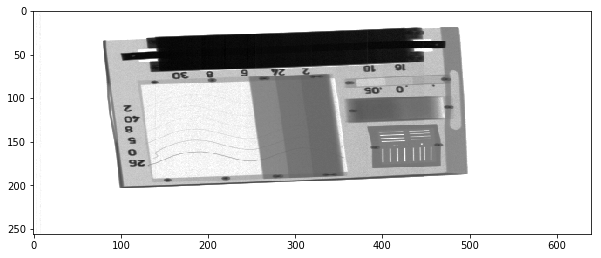

In [7]:
print('Fused image')
f=np.clip(c,0,1)
plt.figure(figsize=(10,10))
plt.imshow(f[256:,:],cmap='gray')

In [8]:
f=(f*255).astype(np.uint8)
print('Number of unique values in the fused image',len(np.unique(f)))

Number of unique values in the fused image 209


In [9]:
L1=wiener(L,[5,5])
H1=wiener(H,[5,5])

imfused=f
le=LE
he=HE
if le.size==he.size and le.size==imfused.size:
    print("LE and HE have equal sizes")
else:
    he=imresize(he,size(le))
    imfused=imresize(imfused,size(le))
    print('LE and HE now have same sizes')


LE and HE have equal sizes


In [10]:
x_ax=(L1+H1)/2
#x_ax=x_ax.flatten()
y_ax=H1-L1
#y_ax=y_ax.flatten()

#y_s=9.6275*np.power(x_ax,7)-32.087*np.power(x_ax,6)+42.001*np.power(x_ax,5)-27.569*np.power(x_ax,4)+9.7762*np.power(x_ax,3)-3.077*np.power(x_ax,2)+1.3534*x_ax-0.0037905
#y_al=-38.88*np.power(x_ax,8)+154.27*np.power(x_ax,7)-250.09*np.power(x_ax,6)+213.27*np.power(x_ax,5)-103.09*np.power(x_ax,4)+28.698*np.power(x_ax,3)-5.2513*np.power(x_ax,2)+1.0521*x_ax-0.0023044;
#y_p=-517.83*np.power(x_ax,10)+2470.8*np.power(x_ax,9)-5016.5*np.power(x_ax,8)+5652.2*np.power(x_ax,7)-3864.3*np.power(x_ax,6)+1647*np.power(x_ax,5)-433.65*np.power(x_ax,4)+68.218*np.power(x_ax,3)-6.5501*np.power(x_ax,2)+0.59162*x_ax-0.00034462;

y_s=-1.2*(x_ax**2)+1.16*x_ax-0.002;
y_p=-0.21*(x_ax**2)+0.16*x_ax+0.018;
y_al=-0.65*(x_ax**2)+0.68*x_ax+0.0074;

y_a=(y_p+y_al)/2;
y_b=(y_al+y_s)/2;


In [11]:
choice_v1=np.zeros(y_ax.shape)
choice_v1[y_ax>y_b]=1
choice_v1[y_ax<y_a]=3
choice_v1[choice_v1==0]=2
choice_v1[np.logical_and(x_ax<0.06, y_ax<0.06)]=1
#re=np.zeros()
res=np.zeros((y_ax.size,1,3))
choice_v1=(choice_v1-1).astype(np.uint8)
print('choice matrix sample, unique, shape',choice_v1,np.unique(choice_v1),choice_v1.shape)

choice matrix sample, unique, shape [[2 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 ...
 [0 2 0 ... 0 0 0]
 [2 2 0 ... 0 0 0]
 [0 0 2 ... 0 2 2]] [0 1 2] (512, 640)


In [12]:
clut_p=pandas.read_excel(data_folders+'clut.xlsx')
c_clut=[clut_p.iloc[1:,8:8+3].values,clut_p.iloc[1:,4:4+3].values,clut_p.iloc[1:,:3].values]
chc=[np.expand_dims(i,axis=2) for i in c_clut]

In [13]:
clut_p=np.concatenate(tuple(chc),axis=2)
clut_p[67,:,:]=clut_p[66,:,:]
clut_p[74,:,:]=clut_p[73,:,:]
clut_p=clut_p.astype(np.uint8)

CLUT shades


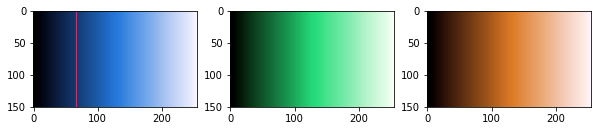

In [14]:
print('CLUT shades')
plt.figure(figsize=(10,60))
plt.subplot(1,3,1)
plt.imshow(np.tile((c_clut[0][:,:]).astype(np.uint8),(150,1,1)))
plt.subplot(1,3,2)
plt.imshow(np.tile(clut_p[:,:,1],(150,1,1)))
plt.subplot(1,3,3)
plt.imshow(np.tile(clut_p[:,:,2],(150,1,1)))

CLUT type, shape, min and max values uint8 (256, 3, 3) 0 255
CLUT shades


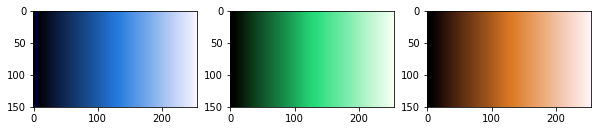

In [16]:
clut=loadmat('clutup1.mat')['CLUT'].astype(np.uint8)
print('CLUT type, shape, min and max values',clut.dtype,clut.shape,clut.min(),clut.max())
print('CLUT shades')
plt.figure(figsize=(10,60))
plt.subplot(1,3,1)
plt.imshow(np.tile(clut[:,:,0],(150,1,1)))
plt.subplot(1,3,2)
plt.imshow(np.tile(clut[:,:,1],(150,1,1)))
plt.subplot(1,3,3)
plt.imshow(np.tile(clut[:,:,2],(150,1,1)))

In [17]:
r,c=imfused.shape
res=np.zeros(f.shape+(3,))
res=np.array([[clut[imfused[i,j],:,choice_v1[i,j]] for j in range(c)] for i in range(r)])

print('Shape of the resultant image:',res.shape)

mask_res=(choice_v1*0.5).reshape(f.shape)

Shape of the resultant image: (512, 640, 3)


protoype pseudocolored image, mask from decision curve


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


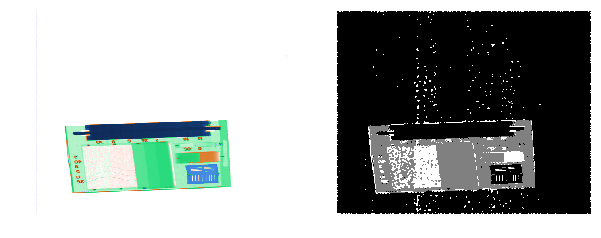

In [18]:
print('protoype pseudocolored image, mask from decision curve')
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1).axis('off')
fig.add_subplot(1,2,1).imshow(res)
fig.add_subplot(1,2,2).axis('off')
fig.add_subplot(1,2,2).imshow(mask_res,cmap='gray')

Ideal, Butterworth, Gaussian (L2R)


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


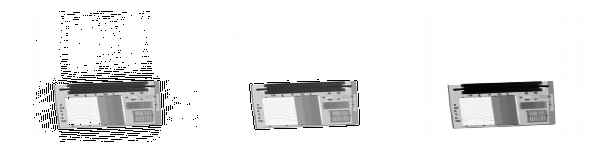

In [19]:

def lpfilter(filt_type,img):
    F=fft2(img)
    m,n=img.shape
    u,v=np.arange(m),np.arange(n)
    idx,idy=np.argwhere(u>m/2),np.argwhere(v>n/2)
    u[idx],v[idy]=u[idx]-m,v[idy]-n
    V,U=np.meshgrid(v,u)
    d,d0=np.hypot(V,U),0.12*n
    
    res_img={
        'ideal':
            ifft2(F*np.reshape((d<=d0).astype(np.uint8),F.shape)),
        'butterworth':
            ifft2(F*np.reshape(1/(1+(d/d0)**8),F.shape)),
        'gaussian':
            ifft2(F*np.reshape(np.exp(-d**2/(2*d0**2)),F.shape))
    }
    return res_img[filt_type].astype(np.uint8)

print('Ideal, Butterworth, Gaussian (L2R)')
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1).axis('off')
fig.add_subplot(1,3,1).imshow(lpfilter('ideal',imfused),cmap='gray')
fig.add_subplot(1,3,2).axis('off')
fig.add_subplot(1,3,2).imshow(lpfilter('butterworth',imfused),cmap='gray')
fig.add_subplot(1,3,3).axis('off')
fig.add_subplot(1,3,3).imshow(lpfilter('gaussian',imfused),cmap='gray')

Final Result


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


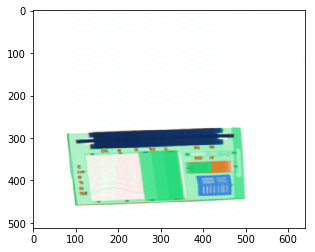

In [20]:
print('Final Result')
for i in range(3):
    res[:,:,i]=lpfilter('gaussian',res[:,:,i]);
plt.imshow(res)

In [ ]:
imsave('imfused.png',imfused)